In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/my_data")
os.listdir()

['rossmann-store-sales.zip',
 'data',
 'decsion_tree.sav',
 'decsion_tree.pkl',
 'decision_tree.pkl',
 'train_df.csv',
 'rf_model.pkl',
 'random_forest.pkl',
 'data_sample.csv',
 'rf_regressor.pkl',
 'app.py']

In [4]:
!unzip rossmann-store-sales.zip


Archive:  rossmann-store-sales.zip
warning [rossmann-store-sales.zip]:  zipfile is empty


In [5]:
train=pd.read_csv('/content/drive/MyDrive/my_data/data/train.csv')
test=pd.read_csv('/content/drive/MyDrive/my_data/data/test.csv')
store=pd.read_csv('/content/drive/MyDrive/my_data/data/store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#merge the train and test to the store dataframe
train_df=pd.merge(left=store, right=train, left_on='Store', right_on='Store')
test_df=pd.merge(left=store, right=test, left_on='Store', right_on='Store')

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   StoreType                  1017209 non-null  object 
 2   Assortment                 1017209 non-null  object 
 3   CompetitionDistance        1014567 non-null  float64
 4   CompetitionOpenSinceMonth  693861 non-null   float64
 5   CompetitionOpenSinceYear   693861 non-null   float64
 6   Promo2                     1017209 non-null  int64  
 7   Promo2SinceWeek            509178 non-null   float64
 8   Promo2SinceYear            509178 non-null   float64
 9   PromoInterval              509178 non-null   object 
 10  DayOfWeek                  1017209 non-null  int64  
 11  Date                       1017209 non-null  object 
 12  Sales                      1017209 non-null  int64  
 13  Customers   

Data Preprocessing

In [8]:
#replace missing values with mean
def fill_mean(dataframe,column):
    dataframe[column].fillna(dataframe[column].mean(), inplace = True)
    return dataframe

# replacing with the median
def fill_median(dataframe,column):
    dataframe[column].fillna(dataframe[column].median(), inplace = True)
    return dataframe

#fill with mode
def fill_mode(dataframe,column):
    dataframe[column].fillna(dataframe[column].mode(), inplace = True)
    return dataframe

#replaces all missing values with 0
def fill_with_0(dataframe):
    dataframe.fillna(0, inplace=True)
    return dataframe

#fill with the previous values   
def fill_before(dataframe,column):
    dataframe.fillna(method='pad', inplace=True)
    return dataframe

#fill with the next values   
def fill_next(dataframe,column):
    dataframe.fillna(method='bfill', inplace=True)
    return dataframe

train_df=fill_mean(train_df,'CompetitionDistance')
train_df=fill_mode(train_df,'CompetitionOpenSinceMonth')
train_df=fill_mode(train_df,'CompetitionOpenSinceYear')
train_df=fill_mode(train_df,'Promo2SinceWeek')
train_df=fill_median(train_df,'Promo2SinceYear')
train_df=fill_median(train_df,'Promo2SinceWeek')
train_df=fill_next(train_df,'PromoInterval')
train_df=fill_before(train_df,'PromoInterval')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   StoreType                  1017209 non-null  object 
 2   Assortment                 1017209 non-null  object 
 3   CompetitionDistance        1017209 non-null  float64
 4   CompetitionOpenSinceMonth  1017209 non-null  float64
 5   CompetitionOpenSinceYear   1017209 non-null  float64
 6   Promo2                     1017209 non-null  int64  
 7   Promo2SinceWeek            1017209 non-null  float64
 8   Promo2SinceYear            1017209 non-null  float64
 9   PromoInterval              1017209 non-null  object 
 10  DayOfWeek                  1017209 non-null  int64  
 11  Date                       1017209 non-null  object 
 12  Sales                      1017209 non-null  int64  
 13  Customers   

In [10]:
#convert Date to datetime format 
def convert_str_datetime(df,col):
    df[col]=pd.to_datetime(df.Date)
    return df
    
convert_str_datetime(train_df,'Date') 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,14.0,2012.0,"Jan,Apr,Jul,Oct",5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


In [11]:
def feature_creation(data):
  data['Year'] = data.Date.dt.year
  data['Month'] = data.Date.dt.month
  data['Day'] = data.Date.dt.day
  data['DayOfWeek'] = data.Date.dt.dayofweek
  data['WeekOfYear'] = data.Date.dt.weekofyear

    #calculate the length of time promotion has been running
  data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
  data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)

  #calculate the length of time competiton has been in business
  data['CompetitionOpen']=12*(data.Year-data.CompetitionOpenSinceYear)+(data.Month-data.CompetitionOpenSinceMonth)
  data['CompetitionOpen']=data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

    

  return data
    
train_df=feature_creation(train_df)
train_df=train_df.drop(columns='Date')
train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,PromoOpen,CompetitionOpen
0,1,c,a,1270.0,9.0,2008.0,0,14.0,2012.0,"Jan,Apr,Jul,Oct",4,5263,555,1,1,0,1,2015,7,31,31,40.25,82.0
1,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",3,5020,546,1,1,0,1,2015,7,30,31,38.25,82.0
2,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",2,4782,523,1,1,0,1,2015,7,29,31,38.25,82.0
3,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",1,5011,560,1,1,0,1,2015,7,28,31,38.25,82.0
4,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",0,6102,612,1,1,0,1,2015,7,27,31,38.25,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,4771,339,1,0,0,1,2013,1,5,1,6.75,81.0
1017205,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,4540,326,1,0,0,1,2013,1,4,1,6.75,81.0
1017206,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,4297,300,1,0,0,1,2013,1,3,1,6.75,81.0
1017207,1115,d,c,5350.0,4.0,2006.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,3697,305,1,0,0,1,2013,1,2,1,6.75,81.0


In [12]:
#train_df.to_csv('train_df.csv')

In [13]:
#numerical variables
num_cols=['Store','CompetitionDistance','PromoOpen', 'CompetitionOpen', 'Promo2',
        'DayOfWeek','Open', 'Promo',  'SchoolHoliday','Year', 'Month', 'Day', 'WeekOfYear']
new_num_cols=train_df[num_cols]

#categorical variables
cat_cols=['StoreType','Assortment','StateHoliday','PromoInterval']
train_df[cat_cols]
#one-hot encoding the categorical columns
cols_new_cat=pd.get_dummies(train_df[cat_cols],drop_first=True)

#add the one-hot encoded columns to the dataframe
cols_data=pd.concat([train_df,cols_new_cat],axis=1)
cols_data

all_cols_cat=list(cols_new_cat.columns)
all_cols_cat

#the input columns
cols_input=num_cols+all_cols_cat
cols_input

['Store',
 'CompetitionDistance',
 'PromoOpen',
 'CompetitionOpen',
 'Promo2',
 'DayOfWeek',
 'Open',
 'Promo',
 'SchoolHoliday',
 'Year',
 'Month',
 'Day',
 'WeekOfYear',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_b',
 'Assortment_c',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'PromoInterval_Jan,Apr,Jul,Oct',
 'PromoInterval_Mar,Jun,Sept,Dec']

In [14]:
train_data=cols_data[cols_input+['Sales']]
train_data

,Store,CompetitionDistance,PromoOpen,CompetitionOpen,Promo2,DayOfWeek,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Sales
0,1,1270.0,40.25,82.0,0,4,1,1,1,2015,7,31,31,0,1,0,0,0,1,0,0,0,1,0,5263
1,1,1270.0,38.25,82.0,0,3,1,1,1,2015,7,30,31,0,1,0,0,0,1,0,0,0,1,0,5020
2,1,1270.0,38.25,82.0,0,2,1,1,1,2015,7,29,31,0,1,0,0,0,1,0,0,0,1,0,4782
3,1,1270.0,38.25,82.0,0,1,1,1,1,2015,7,28,31,0,1,0,0,0,1,0,0,0,1,0,5011
4,1,1270.0,38.25,82.0,0,0,1,1,1,2015,7,27,31,0,1,0,0,0,1,0,0,0,1,0,6102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5350.0,6.75,81.0,1,5,1,0,1,2013,1,5,1,0,0,1,0,1,1,0,0,0,0,1,4771
1017205,1115,5350.0,6.75,81.0,1,4,1,0,1,2013,1,4,1,0,0,1,0,1,1,0,0,0,0,1,4540
1017206,1115,5350.0,6.75,81.0,1,3,1,0,1,2013,1,3,1,0,0,1,0,1,1,0,0,0,0,1,4297
1017207,1115,5350.0,6.75,81.0,1,2,1,0,1,2013,1,2,1,0,0,1,0,1,1,0,0,0,0,1,3697


In [17]:
train_data1=train_data.sample(5000)
train_data1

,Store,CompetitionDistance,PromoOpen,CompetitionOpen,Promo2,DayOfWeek,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Sales
10414,12,1070.0,62.75,15.0,1,1,1,0,0,2015,6,9,24,0,0,0,0,1,1,0,0,0,1,0,5772
788933,866,9680.0,16.75,21.0,1,2,1,0,0,2014,6,11,24,0,0,1,0,0,1,0,0,0,0,0,4661
1017130,1115,5350.0,9.50,83.0,1,2,1,1,0,2013,3,20,12,0,0,1,0,1,1,0,0,0,0,1,5459
806795,885,480.0,13.50,91.0,0,6,0,0,0,2013,7,14,28,0,0,0,0,0,1,0,0,0,1,0,0
654884,720,15320.0,15.00,39.0,1,1,1,0,0,2014,6,24,26,0,0,0,0,1,1,0,0,0,0,0,4568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778423,854,4770.0,36.50,38.0,1,3,1,1,0,2013,4,11,15,0,1,0,0,0,1,0,0,0,1,0,6598
532764,584,1360.0,29.75,0.0,1,5,1,0,0,2013,3,9,10,0,0,1,0,0,1,0,0,0,0,1,4347
241478,266,360.0,36.75,0.0,1,5,1,0,0,2014,3,22,12,0,0,0,0,1,1,0,0,0,0,1,1575
855237,939,1340.0,27.00,23.0,0,2,1,1,0,2014,8,20,34,0,0,1,0,0,0,0,0,0,1,0,5738


In [18]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,balanced_accuracy_score,mean_squared_error,mean_absolute_error
from sklearn import tree
from sklearn.decomposition import PCA

In [19]:
estimators=[('reduce_dim',PCA())]
pipe=Pipeline(estimators)

target='Sales'
used_cols=[c for c in train_data1.columns.tolist() if c not in [target]]

X=train_data1[used_cols]
y=train_data1[target]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

#shape of train and test splits
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3000, 24), (2000, 24), (3000,), (2000,))

In [20]:
#making a pipeline and modelling

scaler=preprocessing.RobustScaler()
num_transformer=make_pipeline(scaler)
preprocessor=ColumnTransformer(transformers=[('num',num_transformer,used_cols)])

In [21]:
#choosing model
model_name=tree.DecisionTreeClassifier()

#giving all values to pipeline
pipe=make_pipeline(preprocessor,model_name)
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('robustscaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                             

In [22]:
#make predictions on training set
y_pred=pipe.predict(X_train)

#make predictions on test set
y_pred_test=pipe.predict(X_test)



In [23]:
#print results
print("accuracy:");
print("="*len("Accuracy:"))
print(f"TRAIN:{accuracy_score(y_train,y_pred)}")
print(f"TEST:{accuracy_score(y_test,y_pred_test)}")    

print("\nBalanced Accuracy:");
print("="*len("Balanced Accuracy:"))
print(f"TRAIN:{balanced_accuracy_score(y_train,y_pred)}")
print(f"TEST:{balanced_accuracy_score(y_test,y_pred_test)}")  

#Root Mean Squared Error on train and test data
print('RMSE on train data:',mean_squared_error(y_train,y_pred)**(0.5))
print('RMSE on test data:',mean_squared_error(y_test,y_pred_test)**(0.5))

accuracy:
TRAIN:1.0
TEST:0.183

Balanced Accuracy:
TRAIN:1.0
TEST:0.0006752194463200541
RMSE on train data: 0.0
RMSE on test data: 3553.048764582327


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [24]:
from sklearn.ensemble import RandomForestRegressor
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=.2,random_state=0)
#using the RandomForest model
rf_model=RandomForestRegressor(n_estimators=15)
rf_model.fit(X_train,y_train)
#make predictions on training set
y_pred=rf_model.predict(X_val)


#print results
mean_squared_error(y_val,y_pred)
print("Mean squared error for validation data:");
print("="*len("Mean Squared Error:"))
print("Mean squared error for validation data:",mean_squared_error(y_val,y_pred))
 

print("\nMean Absolute Error:");
print("="*len("Mean Absolute Error:"))
print(f"Mean absolute error for validation data:", mean_absolute_error(y_val,y_pred))




Mean squared error for validation data:
Mean squared error for validation data: 5967372.943718518

Mean Absolute Error:
Mean absolute error for validation data: 1626.1466666666668


Post Prediction analysis



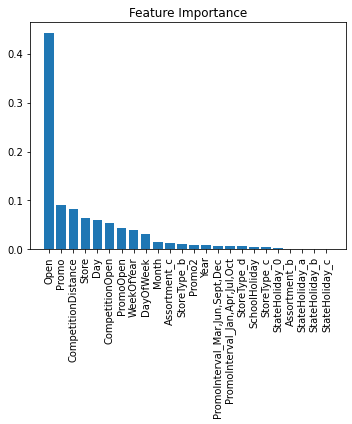

In [25]:
#Feature Importance for the random forest model
importances=rf_model.feature_importances_

sorted_indices=np.argsort(importances)[::-1]

plt.figure(figsize=(5,6))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[sorted_indices],align='center')
plt.xticks(range(X_train.shape[1]),X_train.columns[sorted_indices],rotation=90)
plt.tight_layout()
plt.show()

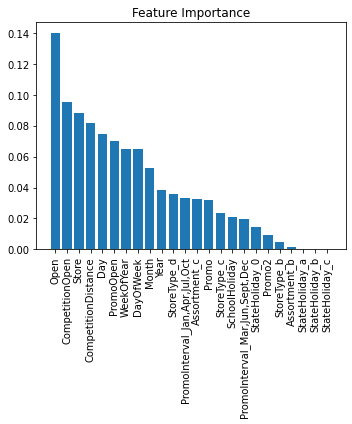

In [26]:
#feature importance for decision tree model

importances=model_name.feature_importances_
sorted_indices=np.argsort(importances)[::-1]

plt.figure(figsize=(5,6))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[sorted_indices],align='center')
plt.xticks(range(X_train.shape[1]),X_train.columns[sorted_indices],rotation=90)
plt.tight_layout()
plt.show()

Serialize the model

In [27]:
import pickle
from datetime import datetime

#saving decsion tree model to disk
filename='decision_tree.pkl'
pickle.dump(model_name,open(filename,'wb'))

with open ('decision_tree.pkl','wb') as db:
   date=datetime.now().timestamp()
   pickle.dump(date,db)
 

In [28]:
#saving random forest model to disk

filename='rf_model.pkl'
pickle.dump(model_name,open(filename,'wb'))

with open ('random_forest.pkl','wb') as rf:
   date=datetime.now().timestamp()
   pickle.dump(date,rf)

In [29]:
models=[rf_model,model_name]

with open("/pickle/30-07-2021-20-51-03-00.pkl","wb") as f:
  for model in models:
    pickle.dump(model,f)

FileNotFoundError: ignored